In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import Image

import matplotlib as mpl
mpl.rcParams.update({'font.size': 10})

%matplotlib nbagg

In [4]:
def sin(theta):
    return np.sin(theta*np.pi/180.)

def cos(theta):
    return np.cos(theta*np.pi/180.)

## Load RIXS

In [5]:
with open('120meV_exchange/RIXS_pol_11_out.spec') as fin:
    header = [fin.readline() for n in range(4)]

num_spectra = int(header[0][:-1].split(' ')[-1])
Emin1, Emax1 = -7., -3.
E1 = np.linspace(Emin1, Emax1, num_spectra)

file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(1, 1)
data = np.loadtxt(file_name, skiprows=5)
E2 = data[:,0]
RIXSmap = data[:,2::2]

In [6]:
def get_rixs(out_pol, in_pol):
    cutrow = 300

    file_name = 'zero_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap0 = -data[:,2::2]
    
    file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap120 = -data[:,2::2]
    
    RIXSmap = np.vstack((RIXSmap120[:cutrow], RIXSmap0[cutrow:]))
    
    return RIXSmap

pol_iter = [(out_pol, in_pol) for out_pol in range(3) for in_pol in range(3)]
RIXSmaps = [get_rixs(out_pol+1, in_pol+1) for out_pol, in_pol in pol_iter]

## Get XAS

In [7]:
XAS = sum(RIXSmaps).sum(axis=0)
#fig, ax = plt.subplots()
#ax.plot(E1, XAS, '.-')
Eres = E1[np.argmax(XAS)]
print('Resonance at {:.3f}'.format(Eres))

Resonance at -5.200


## Get spectra

In [8]:
spectra = [RIXSmap[:,np.argmax(XAS)] for RIXSmap in RIXSmaps]

spectra_matrix = np.zeros((len(E2), 3, 3))
for spectrum, (in_pol, out_pol) in zip(spectra, pol_iter):
    spectra_matrix[:, in_pol, out_pol] = spectrum

maxval = np.max(spectra_matrix)

## Define functions

In [19]:
def norm(v):
    return np.abs(v/np.sqrt((v**2).sum()))

def make_a(k, kp, in_pol):
    sigma = np.cross(k, kp)
    if in_pol == 'sigma':
        return norm(sigma)
    elif in_pol == 'pi':
        pi = np.cross(k, sigma)
    return norm(pi)

def make_e(k, kp):
    sigma = np.cross(k, kp)
    pi = np.cross(sigma, kp)
    return norm(sigma+pi)

def rot_mat(u, phi):
    R = np.array([[cos(phi) + u[0]**2*(1-cos(phi)),
                  u[0]*u[1]*(1-cos(phi)) - u[2]*sin(phi), 
                  u[0]*u[2]*(1-cos(phi)) + u[1]*sin(phi)],

                 [u[1]*u[0]*(1-cos(phi)) + u[2]*sin(phi),  
                  cos(phi) + u[1]**2 *(1-cos(phi)),
                  u[1]*u[2]*(1-cos(phi)) -u[0]*sin(phi)],

                 [u[2]*u[0]*(1-cos(phi)) - u[1]*sin(phi),
                  u[2]*u[1]*(1-cos(phi)) + u[0]*sin(phi),
                  cos(phi) + u[2]**2 *(1-cos(phi))]
                 ])
    return R

def get_orbital_ints_azi(k_i, kp_i, u, phi, in_pol):
    spectrum = get_spectrum(k_i, kp_i, u, phi, in_pol)
    return get_energies(spectrum)

def get_spectrum(k_i, kp_i, u, phi, in_pol):
    R = rot_mat(u, phi)
    k = np.matmul(R, k_i)
    kp = np.matmul(R, kp_i)
    
    #print("phi {} k {} kp {}".format(phi, k, kp))
    
    absorption_pol = make_a(k, kp, in_pol)
    emitted_pol = make_e(k, kp)
    
    #print("abs {} emit {}".format(absorption_pol, emitted_pol))
    
    M = np.outer(emitted_pol, absorption_pol)
    print(M)
    spectrum = (M*spectra_matrix).sum(axis=(1,2))
    
    return spectrum

def get_energies(spectrum):
    mag = np.interp(0.25, E2, spectrum)
    z = np.interp(1.68, E2, spectrum)
    xy = np.interp(1.79, E2, spectrum)
    xz = np.interp(2.10, E2, spectrum)
    
    return mag, z, xy, xz

## Compute azimuth for incident x-rays along c-axis

<IPython.core.display.Javascript object>


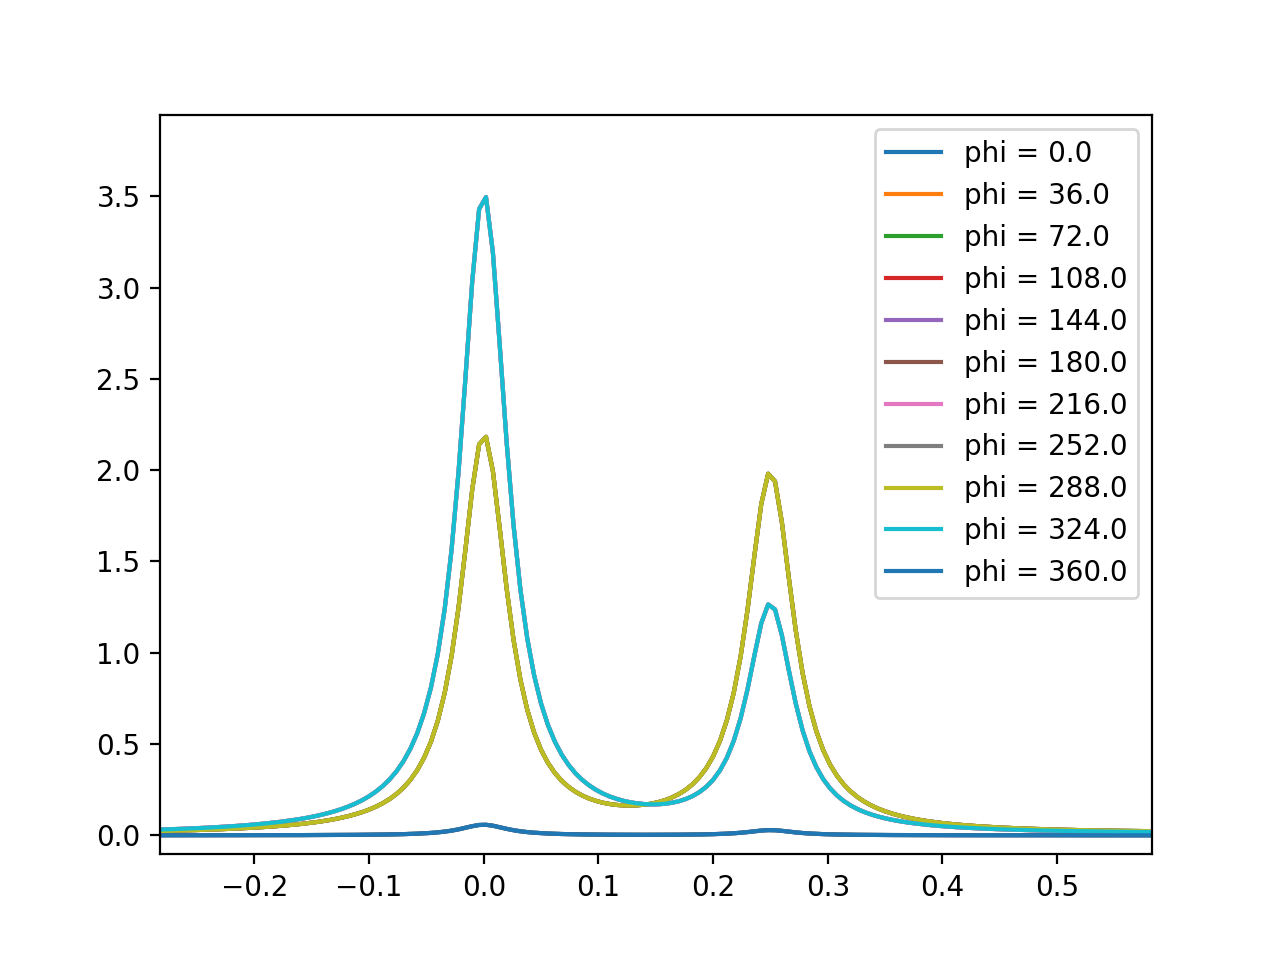

[[ 0.          0.          0.70710678]
 [ 0.          0.          0.70710678]
 [ 0.          0.          0.        ]]
[[ 0.          0.41562694  0.5720614 ]
 [ 0.          0.33624926  0.4628074 ]
 [ 0.          0.24429938  0.33624926]]
[[ 0.          0.67249851  0.21850801]
 [ 0.          0.20781347  0.06752269]
 [ 0.          0.63958409  0.20781347]]
[[ 0.          0.67249851  0.21850801]
 [ 0.          0.20781347  0.06752269]
 [ 0.          0.63958409  0.20781347]]
[[ 0.          0.41562694  0.5720614 ]
 [ 0.          0.33624926  0.4628074 ]
 [ 0.          0.24429938  0.33624926]]
[[  0.00000000e+00   8.65956056e-17   7.07106781e-01]
 [  0.00000000e+00   8.65956056e-17   7.07106781e-01]
 [  0.00000000e+00   1.06049031e-32   8.65956056e-17]]
[[ 0.          0.41562694  0.5720614 ]
 [ 0.          0.33624926  0.4628074 ]
 [ 0.          0.24429938  0.33624926]]
[[ 0.          0.67249851  0.21850801]
 [ 0.          0.20781347  0.06752269]
 [ 0.          0.63958409  0.20781347]]
[[ 0.      

In [27]:
k_i = np.array([1, 0, 0])
kp_i = np.array([0, 0, 1])

#u = np.array([cos(Q_ang), 0, sin(Q_ang)])
u = np.array([1, 0, 0])



fig, ax = plt.subplots()
for phi in np.linspace(0,360, 11):
    spectrum = get_spectrum(k_i, kp_i, u, phi, 'pi')
    ax.plot(E2, spectrum, label="phi = {}".format(phi))

ax.legend()

[[ 0.45451948  0.          0.        ]
 [ 0.70710678  0.          0.        ]
 [ 0.54167522  0.          0.        ]]
[[  4.43159130e-01   7.02996718e-03   2.59996839e-05]
 [  7.18123771e-01   1.13918144e-02   4.21315725e-05]
 [  5.36336323e-01   8.50806516e-03   3.14662926e-05]]
[[  4.31518616e-01   1.36936917e-02   1.01297464e-04]
 [  7.28734611e-01   2.31254615e-02   1.71067865e-04]
 [  5.30783835e-01   1.68437466e-02   1.24599622e-04]]
[[  4.19610358e-01   1.99811696e-02   2.21740813e-04]
 [  7.38928090e-01   3.51865659e-02   3.90482533e-04]
 [  5.25023587e-01   2.50007779e-02   2.77445861e-04]]
[[  4.07447105e-01   2.58828589e-02   3.83048130e-04]
 [  7.48693469e-01   4.75603511e-02   7.03859787e-04]
 [  5.19061587e-01   3.29731090e-02   4.87978850e-04]]
[[  3.95041924e-01   3.13896919e-02   5.80815255e-04]
 [  7.58020496e-01   6.02316575e-02   1.11448897e-03]
 [  5.12904017e-01   4.07549126e-02   7.54103450e-04]]
[[ 0.38240818  0.03649309  0.00081052]
 [ 0.76689942  0.07318496  0

<IPython.core.display.Javascript object>


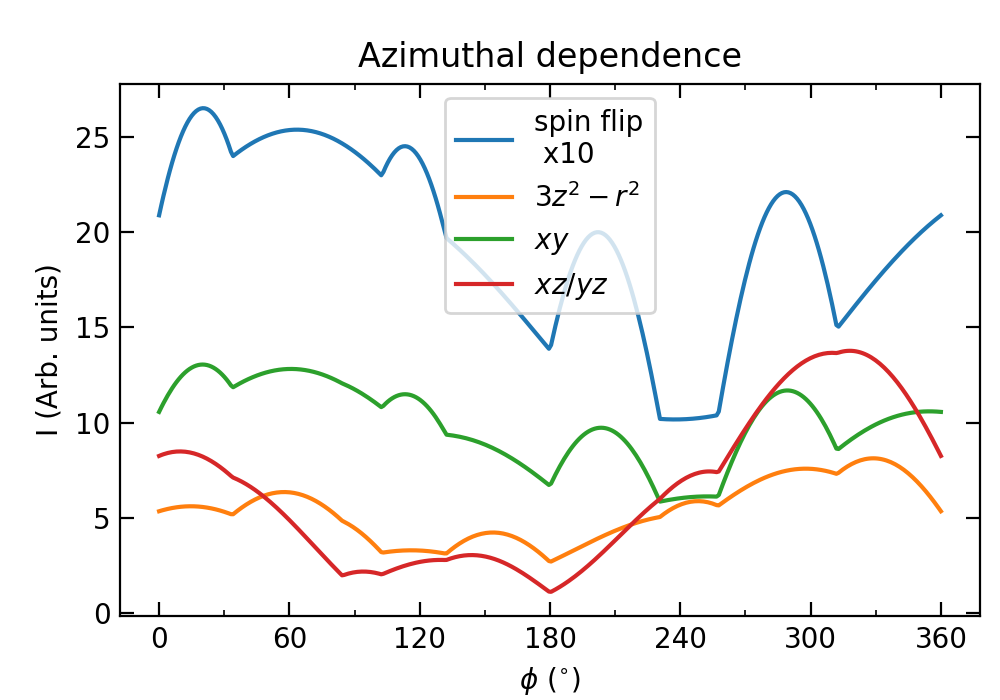

In [24]:
tth = 130
th_o = 40
Q_ang = th_o + (180-tth)/2

k_i = np.array([0, 0, 1])
kp_i = np.array([cos(th_o), 0, sin(th_o)])
u = np.array([cos(Q_ang), 0, sin(Q_ang)])

phis = np.linspace(0, 360, 360)
intensities = np.array([get_orbital_ints_azi(k_i, kp_i, u, phi, 'pi') for phi in phis])


fig, ax = plt.subplots(figsize=(5, 3.5))

ax.plot(phis, intensities[:,0]*10, label='spin flip\n x10')
ax.plot(phis, intensities[:,1], label='$3z^2-r^2$')
ax.plot(phis, intensities[:,2], label='$xy$')
ax.plot(phis, intensities[:,3], label='$xz/yz$')
ax.set_xlabel('$\phi$ ($^{\circ}$)')
ax.set_ylabel('I (Arb. units)')
ax.legend()

ax.tick_params(which='major', direction='in', bottom=True, top=True, left=True, right=True, length=5)
ax.tick_params(which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=2)
ax.minorticks_on()
ax.xaxis.set_major_locator(MultipleLocator(60))
ax.xaxis.set_minor_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.set_title(r'Azimuthal dependence')

fig.subplots_adjust(bottom=0.12, left=0.12, right=0.98)

fig.savefig('azimuthal.pdf')

In [16]:
intensities

array([[  2.08761148,   5.34772284,  10.56036265,   8.25021433],
       [  2.13953965,   5.38179789,  10.79377705,   8.29700508],
       [  2.18925418,   5.4136119 ,  11.0170122 ,   8.33865287],
       ..., 
       [  2.06938979,   5.66866271,  10.57763497,   8.69963658],
       [  2.0785913 ,   5.50996905,  10.56993798,   8.47606764],
       [  2.08761148,   5.34772284,  10.56036265,   8.25021433]])

In [22]:
make_e(np.array([1,0,0]), np.array([0,0,1]))

array([ 0.70710678,  0.70710678,  0.        ])